In [1]:
import pandas as pd
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

In [2]:

def version_to_run_config(unix_seconds):
    # "/mnt/ssd-2/spar/alexm/dlk-benchmarking/wandb/run-20230718_002056-tka2fnu1/files/config.yaml"
    for child in os.listdir("/mnt/ssd-2/spar/alexm/dlk-benchmarking/wandb/"):
        if not os.path.isdir(f"/mnt/ssd-2/spar/alexm/dlk-benchmarking/wandb/{child}"):
            continue
        # check if unix_seconds is a substring of "save_name" of the in the config.yaml file
        # (if it exists)
        config_path = f"/mnt/ssd-2/spar/alexm/dlk-benchmarking/wandb/{child}/files/config.yaml"
        with open(config_path, "r") as f:
            config = yaml.safe_load(f)
        if "save_name" in config:
            if str(unix_seconds) in config["save_name"]["value"]:
                return child, config
    return None, None

version_to_run_config(1690413778)
version_to_run = {
    "1690413778": {
        "wandb": "https://wandb.ai/latent-knowledge/weak-deception/runs/dvqqql8i",
        "lora-rank": 256,
        "kl-weight": 0.1,
        "objective": "standard",
        "lie-mode": "defier",
        "description": "6.4% of trainable parameters tuned."}}
def get_cfg_str(config, keys=["lora_rank", "objective", "lie_mode", "n_epochs"]):
    vals = []
    for key in keys:
        vals.append(f"{key}=" + str(config[key]["value"]))
    return "; ".join(vals)

def get_url(child):
    return f"https://wandb.ai/latent-knowledge/weak-deception/runs/{child.split('-')[-1]}"


In [27]:
# 1692126045 p=1
# 1692125930 p=0.9
# 1692117229 p=0.3
version = 1692117229 # versions[-1]
modifier = "0.3"
from_ds_name = f"atmallen/sloppy_addition_bob_{modifier}"
to_ds_name = f"atmallen/sloppy_addition_alice_{modifier}"
transfer = True
transfer_from_base = False
inlp_iter = 0  # 4 has high transfer auroc to bob in last layers for 1692126045

from_reporter_dir = f"../../elk/elk-reporters/base-to-deceptive-lora/v{version}/{from_ds_name}" if transfer_from_base else f"../../elk/elk-reporters/deceptive-lora/v{version}/{from_ds_name}"
transfer_reporter_dir = f"../../elk/elk-reporters/base-to-deceptive-lora/v{version}/{from_ds_name}/transfer/{to_ds_name}" if transfer_from_base else f"../../elk/elk-reporters/deceptive-lora/v{version}/{from_ds_name}/transfer/{to_ds_name}"
reporter_dir = from_reporter_dir if not transfer else transfer_reporter_dir

methods = {"LR": "lr_eval.csv", "reporter": "eval.csv", "LM": "lm_eval.csv"}
master_df = pd.DataFrame()
for method, eval_file in methods.items():
    df = pd.read_csv(os.path.join(reporter_dir, eval_file))
    if method == "LR":
        df = df[df["inlp_iter"] == inlp_iter]
    df["method"] = method
    master_df = pd.concat([master_df, df])
master_df

child, config = version_to_run_config(version)
cfg_str = get_cfg_str(config)
wandb_url = get_url(child)
print(cfg_str)
print(wandb_url)

lora_rank=2; objective=standard; lie_mode=honest; n_epochs=1
https://wandb.ai/latent-knowledge/weak-deception/runs/q1u9v6ez


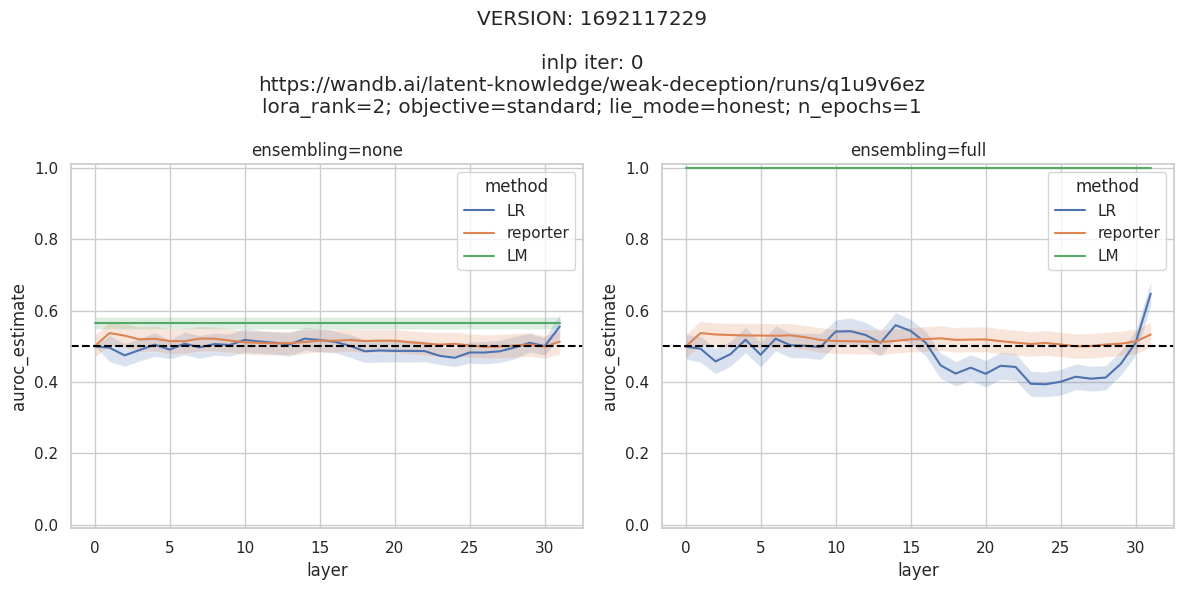

https://wandb.ai/latent-knowledge/weak-deception/runs/q1u9v6ez


In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
metric = "auroc"
ens = "none"
df = master_df[master_df["ensembling"] == ens]
sns.lineplot(data=df, x="layer", y=f"{metric}_estimate", hue="method", errorbar=None)
for method in methods:
    sub_df = df[df["method"] == method]
    plt.fill_between(sub_df["layer"], sub_df[f"{metric}_lower"], sub_df[f"{metric}_upper"], alpha=0.2)
plt.title(f"ensembling={ens}")
plt.axhline(y=0.5, color="black", linestyle="--")
plt.ylim([-0.01, 1.01])
plt.subplot(1, 2, 2)
ens = "full"
df = master_df[master_df["ensembling"] == ens]
sns.lineplot(data=df, x="layer", y=f"{metric}_estimate", hue="method", errorbar=None)
for method in methods:
    sub_df = df[df["method"] == method]
    plt.fill_between(sub_df["layer"], sub_df[f"{metric}_lower"], sub_df[f"{metric}_upper"], alpha=0.2)
plt.title(f"ensembling={ens}")
plt.axhline(y=0.5, color="black", linestyle="--")
plt.ylim([-0.01, 1.01])

maybe_trans = 'transfer from reporter trained on base model\n' if transfer_from_base else ''
plt.suptitle(f"VERSION: {version}\n{maybe_trans}\ninlp iter: {inlp_iter}\n{wandb_url}\n{cfg_str}")
plt.tight_layout()
plt.show()
print(wandb_url)
